### Imports

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
random_state = 42

### Load data

In [3]:
df = pd.read_csv(r"..\dataset\heart_2020_cleaned.csv", sep=",", encoding="utf-8")

print(df.shape)
df.head()

(319795, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


#### Memory Reduction Algorithm

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 43.92 MB
Memory usage after optimization is: 6.71 MB
Decreased by 84.7%


### Exploratory Data Analysis

In [6]:
df['HeartDisease'].value_counts()  

# Unbalanced dataset
# False Posistives > False Negatives -> Evaluation Metric: 

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [7]:
for col in df.columns:
    print(col + "\n" + str(df[col].value_counts()) + "\n")

HeartDisease
No     292422
Yes     27373
Name: HeartDisease, dtype: int64

BMI
25.093750    4023
26.625000    3774
25.843750    3126
27.453125    2767
27.437500    2725
             ... 
14.578125       1
13.593750       1
15.953125       1
94.875000       1
60.187500       1
Name: BMI, Length: 2191, dtype: int64

Smoking
No     187887
Yes    131908
Name: Smoking, dtype: int64

AlcoholDrinking
No     298018
Yes     21777
Name: AlcoholDrinking, dtype: int64

Stroke
No     307726
Yes     12069
Name: Stroke, dtype: int64

PhysicalHealth
0.0     226589
30.0     19509
2.0      14880
1.0      10489
3.0       8617
5.0       7606
10.0      5453
15.0      5012
7.0       4629
4.0       4468
20.0      3216
14.0      2893
6.0       1270
25.0      1164
8.0        924
21.0       626
12.0       605
28.0       446
29.0       204
9.0        180
18.0       167
16.0       135
27.0       124
17.0       110
13.0        91
22.0        89
11.0        85
24.0        67
26.0        66
23.0        46
19.0      

In [8]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.0,319795.0,319795.0
mean,NaN,NaN,NaN,NaN
std,0.000000,0.0,0.0,0.0
min,12.023438,0.0,0.0,1.0
25%,24.031250,0.0,0.0,6.0
50%,27.343750,0.0,0.0,7.0
75%,31.421875,2.0,3.0,8.0
max,94.875000,30.0,30.0,24.0


In [9]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [10]:
""" plt.figure(figsize=(30, 15))

heatmap = sns.heatmap(df.drop(columns=["HeartDisease"]).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=18) """

' plt.figure(figsize=(30, 15))\n\nheatmap = sns.heatmap(df.drop(columns=["HeartDisease"]).corr(), vmin=-1, vmax=1, annot=True)\nheatmap.set_title(\'Correlation Heatmap\', fontdict={\'fontsize\':10}, pad=18) '

### Preprocessing

In [11]:
binary_cols = ['HeartDisease', 'Smoking', 'AlcoholDrinking', "Stroke", "DiffWalking", 
               "Sex", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

label_encoder = LabelEncoder()

for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])

df.head(1)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.59375,1,0,0,3.0,30.0,0,0,55-59,White,Yes,1,Very good,5.0,1,0,1


In [12]:
for col in binary_cols:
    print(str(df[col].value_counts()) + "\n")

0    292422
1     27373
Name: HeartDisease, dtype: int64

0    187887
1    131908
Name: Smoking, dtype: int64

0    298018
1     21777
Name: AlcoholDrinking, dtype: int64

0    307726
1     12069
Name: Stroke, dtype: int64

0    275385
1     44410
Name: DiffWalking, dtype: int64

0    167805
1    151990
Name: Sex, dtype: int64

1    247957
0     71838
Name: PhysicalActivity, dtype: int64

0    276923
1     42872
Name: Asthma, dtype: int64

0    308016
1     11779
Name: KidneyDisease, dtype: int64

0    289976
1     29819
Name: SkinCancer, dtype: int64



In [13]:
category_cols = ["AgeCategory", "Race", "Diabetic", "GenHealth"]

for col in category_cols:
    print(df[col].unique())

['55-59', '80 or older', '65-69', '75-79', '40-44', ..., '45-49', '18-24', '35-39', '30-34', '25-29']
Length: 13
Categories (13, object): ['18-24', '25-29', '30-34', '35-39', ..., '65-69', '70-74', '75-79', '80 or older']
['White', 'Black', 'Asian', 'American Indian/Alaskan Native', 'Other', 'Hispanic']
Categories (6, object): ['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other', 'White']
['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)']
Categories (4, object): ['No', 'No, borderline diabetes', 'Yes', 'Yes (during pregnancy)']
['Very good', 'Fair', 'Good', 'Poor', 'Excellent']
Categories (5, object): ['Excellent', 'Fair', 'Good', 'Poor', 'Very good']


In [14]:
one_hot_cols = pd.get_dummies(df[category_cols])
    
df.drop(category_cols, axis=1, inplace=True)
df = pd.concat([df, one_hot_cols], axis=1) 

print(df.shape)
print(df.head(1))

(319795, 42)
   HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0             0  16.59375        1                0       0             3.0   

   MentalHealth  DiffWalking  Sex  PhysicalActivity  ...  Race_White  \
0          30.0            0    0                 1  ...           1   

   Diabetic_No  Diabetic_No, borderline diabetes  Diabetic_Yes  \
0            0                                 0             1   

   Diabetic_Yes (during pregnancy)  GenHealth_Excellent  GenHealth_Fair  \
0                                0                    0               0   

   GenHealth_Good  GenHealth_Poor  GenHealth_Very good  
0               0               0                    1  

[1 rows x 42 columns]


In [15]:
print(df.columns)

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White', 'Diabetic_No',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good'],
      dtype='object')


In [16]:
continuous_cols = ["BMI", "PhysicalHealth",	"MentalHealth", "SleepTime"]

min_max_scaler = MinMaxScaler()
df[continuous_cols] = min_max_scaler.fit_transform(df[continuous_cols])

print(df.shape)
print(df.head(1))

(319795, 42)
   HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0             0  0.055176        1                0       0        0.099976   

   MentalHealth  DiffWalking  Sex  PhysicalActivity  ...  Race_White  \
0           1.0            0    0                 1  ...           1   

   Diabetic_No  Diabetic_No, borderline diabetes  Diabetic_Yes  \
0            0                                 0             1   

   Diabetic_Yes (during pregnancy)  GenHealth_Excellent  GenHealth_Fair  \
0                                0                    0               0   

   GenHealth_Good  GenHealth_Poor  GenHealth_Very good  
0               0               0                    1  

[1 rows x 42 columns]


In [17]:
Y = df["HeartDisease"]
X = df.drop(columns="HeartDisease")

print(Y.shape)
print(Y.iloc[0])
print(X.shape)
print(X.iloc[0])

(319795,)
0
(319795, 41)
BMI                                    0.055176
Smoking                                1.000000
AlcoholDrinking                        0.000000
Stroke                                 0.000000
PhysicalHealth                         0.099976
MentalHealth                           1.000000
DiffWalking                            0.000000
Sex                                    0.000000
PhysicalActivity                       1.000000
SleepTime                              0.173950
Asthma                                 1.000000
KidneyDisease                          0.000000
SkinCancer                             1.000000
AgeCategory_18-24                      0.000000
AgeCategory_25-29                      0.000000
AgeCategory_30-34                      0.000000
AgeCategory_35-39                      0.000000
AgeCategory_40-44                      0.000000
AgeCategory_45-49                      0.000000
AgeCategory_50-54                      0.000000
AgeCategory_55-

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)

### Models

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  plot_confusion_matrix, classification_report, f1_score
from sklearn.neural_network import MLPClassifier

#### MLP

In [20]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128,64,32), max_iter=200, 
                           activation = 'relu', solver='adam', early_stopping = True,
                           validation_fraction = 0.1,
                           verbose=True, random_state=random_state)

In [21]:
mlp_classifier.fit(X_train.values, y_train.values)

Iteration 1, loss = 0.23145599
Validation score: 0.917136
Iteration 2, loss = 0.22483548
Validation score: 0.917097
Iteration 3, loss = 0.22404009
Validation score: 0.916628
Iteration 4, loss = 0.22348406
Validation score: 0.916940
Iteration 5, loss = 0.22312391
Validation score: 0.916549
Iteration 6, loss = 0.22272951
Validation score: 0.916745
Iteration 7, loss = 0.22224876
Validation score: 0.916940
Iteration 8, loss = 0.22198816
Validation score: 0.917097
Iteration 9, loss = 0.22157039
Validation score: 0.916588
Iteration 10, loss = 0.22123314
Validation score: 0.916667
Iteration 11, loss = 0.22061137
Validation score: 0.916432
Iteration 12, loss = 0.21993885
Validation score: 0.916628
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64, 32),
              random_state=42, verbose=True)

In [22]:
Y_pred = mlp_classifier.predict(X_test.values)

In [23]:
def print_evaluation_metrics(model, x_test, y_test, y_pred):
    
    print(classification_report(y_test, y_pred))
    print(f1_score(y_test, Y_pred))
    plot_confusion_matrix(model, x_test, y_test, colorbar=False)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.57      0.08      0.13      5592

    accuracy                           0.91     63959
   macro avg       0.74      0.53      0.54     63959
weighted avg       0.89      0.91      0.88     63959

0.1329333754341648


d:\Users\MiguelAlbergaria\Anaconda3\envs\Prova\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Users\MiguelAlbergaria\Anaconda3\envs\Prova\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


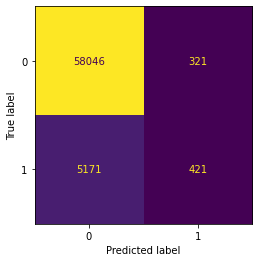

In [24]:
print_evaluation_metrics(mlp_classifier, X_test, y_test, Y_pred)

#### Random Forest

In [25]:
rf_classifier = RandomForestClassifier(random_state=random_state, verbose=2)

In [26]:
rf_classifier.fit(X_train.values, y_train.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   41.2s finished


RandomForestClassifier(random_state=42, verbose=2)

In [27]:
Y_pred = rf_classifier.predict(X_test.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


d:\Users\MiguelAlbergaria\Anaconda3\envs\Prova\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Users\MiguelAlbergaria\Anaconda3\envs\Prova\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


              precision    recall  f1-score   support

           0       0.92      0.98      0.95     58367
           1       0.33      0.12      0.17      5592

    accuracy                           0.90     63959
   macro avg       0.63      0.55      0.56     63959
weighted avg       0.87      0.90      0.88     63959

0.17314066021476865


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


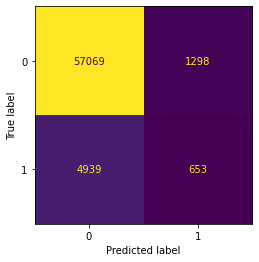

In [28]:
print_evaluation_metrics(rf_classifier, X_test, y_test, Y_pred)

#### Logistic Regression

In [29]:
lr_classifier = LogisticRegression(random_state=random_state, verbose=2)

In [30]:
lr_classifier.fit(X_train.values, y_train.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
d:\Users\MiguelAlbergaria\Anaconda3\envs\Prova\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


LogisticRegression(random_state=42, verbose=2)

In [31]:
Y_pred = lr_classifier.predict(X_test.values)

d:\Users\MiguelAlbergaria\Anaconda3\envs\Prova\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Users\MiguelAlbergaria\Anaconda3\envs\Prova\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.54      0.10      0.17      5592

    accuracy                           0.91     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.91      0.89     63959

0.1689545934530095


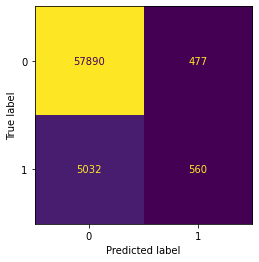

In [32]:
print_evaluation_metrics(lr_classifier, X_test, y_test, Y_pred)

### Save model and encoders

In [33]:
#joblib.dump(rf_classifier, "classifier.pickle")

In [34]:
joblib.dump(label_encoder, "binary_encoder.pickle")

['binary_encoder.pickle']

In [35]:
joblib.dump(min_max_scaler, "min_max_scaler.pickle")

['min_max_scaler.pickle']

In [36]:
categorical_dict = {'age_category':['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'],
                   'race': ['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other', 'White'],
                   'diabetic': ['No', 'No, borderline diabetes', 'Yes', 'Yes (during pregnancy)'],
                   'gen_health': ['Excellent', 'Fair', 'Good', 'Poor', 'Very good']}

print(categorical_dict)



{'age_category': ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'], 'race': ['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other', 'White'], 'diabetic': ['No', 'No, borderline diabetes', 'Yes', 'Yes (during pregnancy)'], 'gen_health': ['Excellent', 'Fair', 'Good', 'Poor', 'Very good']}
